In [1]:
from transformers import pipeline
from PIL import Image
import numpy as np
import pandas as pd

In [2]:
segmenter = pipeline("image-segmentation", model="mattmdjaga/segformer_b2_clothes")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


# Set up functions to Segment Clothes

In [3]:
# Initialize segmentation pipeline
def segment_clothing(img, clothes= ["Upper-clothes", "Pants", "Belt"]):
    # Segment image
    segments = segmenter(img)

    # Create list of masks
    mask_list = []
    for s in segments:
        if(s['label'] in clothes):
            mask_list.append(s['mask'])


    # Paste all masks on top of eachother 
    final_mask = np.array(mask_list[0])
    for mask in mask_list:
        current_mask = np.array(mask)
        final_mask = final_mask + current_mask
            
    # Convert final mask from np array to PIL image
    final_mask = Image.fromarray(final_mask)

    # Apply mask to original image
    img.putalpha(final_mask)

    # display the image
    return img

In [4]:
def batch_segment_clothing(img_dir, out_dir, clothes= ["Hat", "Upper-clothes", "Skirt", "Pants", "Dress", "Belt", "Left-shoe", "Right-shoe", "Scarf"]):
    # Create output directory if it doesn't exist
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    # Iterate through each file in the input directory
    for filename in os.listdir(img_dir):
        if filename.endswith(".jpg") or filename.endswith(".JPG") or filename.endswith(".png") or filename.endswith(".PNG"):
            try:
                # Load image
                img_path = os.path.join(img_dir, filename)
                img = Image.open(img_path).convert("RGBA")

                # Segment clothing
                segmented_img = segment_clothing(img, clothes)

                # Save segmented image to output directory as PNG
                out_path = os.path.join(out_dir, filename.split('.')[0] + ".png")
                segmented_img.save(out_path)

                print(f"Segmented {filename} successfully.")

            except Exception as e:
                print(f"Error processing {filename}: {e}")

        else:
            print(f"Skipping {filename} as it is not a supported image file.")

# scrape website and create csv file

In [5]:
from playwright.async_api import async_playwright

playwright = await async_playwright().start()

browser = await playwright.chromium.launch(headless=True)

page = await browser.new_page()

##### Ralph_Lauren

In [6]:
RL_url = "https://www.ralphlauren.com/women-clothing" 
await page.goto(RL_url)
rl= await page.eval_on_selector_all(
    "[srcset]",
    "elements => elements.map(el => el.getAttribute('srcset'))"
)

#### Uniqlo

In [7]:
uniqlo='https://www.uniqlo.com/us/en/spl/ranking/women'
await page.goto(uniqlo)
unq= await page.eval_on_selector_all(
    "div.fr-ec-product-tile-resize-wrapper img.fr-ec-image__img",
    "elements => elements.map(e => e.src)"
)

### Zara

In [8]:
Zara="https://www.zara.com/us/en/woman-best-sellers-l5912.html?v1=2491343&regionGroupId=41"
await page.goto(Zara)
zara = await page.eval_on_selector_all(
    'img[data-qa-qualifier="media-image"]',
    "elements => elements.map(e => e.src)"
)
zara = [e for e in zara if 'background' not in e]

In [9]:
links=[]
d = pd.DataFrame({'ExistingColumn': range(92)})
rl_extended = rl + ['N/A'] * (len(d) - len(rl))
unq_extended = unq + ['N/A'] * (len(d) - len(unq))
zara_extended = zara + ['N/A'] * (len(d) - len(zara))
d['Ralph_Lauren'] = rl_extended
d['Uniqlo'] = unq_extended
d['Zara'] = zara_extended
links.append(d)

In [10]:
d.drop(columns='ExistingColumn', errors='ignore', inplace=True)
d.to_csv('Image_Sources.csv',index=False)

In [11]:
d.head()

,Ralph_Lauren,Uniqlo,Zara
0,N/A,https://image.uniqlo.com/UQ/ST3/us/imagesgoods...,N/A
1,N/A,https://image.uniqlo.com/UQ/ST3/us/imagesgoods...,N/A
2,N/A,https://image.uniqlo.com/UQ/ST3/us/imagesgoods...,N/A
3,N/A,https://image.uniqlo.com/UQ/ST3/us/imagesgoods...,N/A
4,N/A,https://image.uniqlo.com/UQ/ST3/us/imagesgoods...,N/A


# Read url from the csv file & Segmentation

In [41]:
import urllib.request
from urllib.parse import unquote
import re
import os

df=pd.read_csv('Image_Sources.csv')

In [43]:
path_files=[]
dic={}
for col in df.columns:
    links=df[col]
    # Create a folder for the current column if needed
    os.makedirs(col, exist_ok=True)
    paths=[]
    try: 
        for l in links:
            # URL of the file to download
            url = l

            # Extract the filename from the URL
            filename = url.split("/")[-1]  # Default fallback if Content-Disposition is not available
            filename = unquote(filename)  # Decode URL-encoded characters in the filename

            # Combine column name folder path with filename
            filepath = os.path.join(col, filename)
            
            # Download and save the file
            urllib.request.urlretrieve(url, filepath)
            
            print(f"File downloaded and saved as: {filepath}")
            
            
            # open the file
            image=Image.open(filepath)

            # segment the clothes
            result = segment_clothing(img=image)
            result.save(f'{filepath}.png')
            paths.append(f'{filepath}.png')
    
    except:
        print("This image cound't be found:",l)

    dic[col]=paths
    path_files.append(dic)

File downloaded and saved as: Ralph_Lauren/s7-1485490_alternate10?$plpDeskRFAlt$
File downloaded and saved as: Ralph_Lauren/s7-1485490_alternate10?$plpDeskRFAlt$
File downloaded and saved as: Ralph_Lauren/s7-1485490_lifestyle?$plpDeskRF$
File downloaded and saved as: Ralph_Lauren/s7-1485490_lifestyle?$plpMob$
File downloaded and saved as: Ralph_Lauren/s7-1474896_alternate10?$plpDeskRFAlt$
File downloaded and saved as: Ralph_Lauren/s7-1474896_alternate10?$plpDeskRFAlt$
File downloaded and saved as: Ralph_Lauren/s7-1474896_lifestyle?$plpDeskRF$
File downloaded and saved as: Ralph_Lauren/s7-1474896_lifestyle?$plpMob$
File downloaded and saved as: Ralph_Lauren/s7-1470151_alternate10?$plpDeskRFAlt$
File downloaded and saved as: Ralph_Lauren/s7-1470151_alternate10?$plpDeskRFAlt$
File downloaded and saved as: Ralph_Lauren/s7-1470151_lifestyle?$plpDeskRF$
File downloaded and saved as: Ralph_Lauren/s7-1470151_lifestyle?$plpMob$
File downloaded and saved as: Ralph_Lauren/s7-1446139_lifestyle?$pl

# read the colors

In [30]:
# pip install Pillow scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 8.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 8.4 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [47]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [48]:
def extract_colors(image_path, num_colors=5):
    img = Image.open(image_path)
    # Ensure image is in RGB format
    img = img.convert('RGB')
    
    img = img.resize((256, 256))  # Resize for faster processing
    img_array = np.array(img)
    img_array = img_array.reshape((-1, 3))

    kmeans = KMeans(n_clusters=num_colors)
    kmeans.fit(img_array)
    colors = kmeans.cluster_centers_.astype(int)
    return colors

# Make a color palette

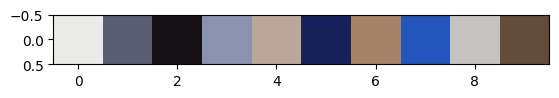

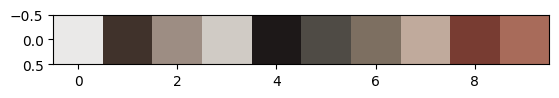

<Figure size 640x480 with 0 Axes>

In [65]:
palettes=[]
for brand,paths in path_files.items():
    image_paths = paths  # Add your image paths
    all_colors = []
        
    for path in image_paths:
        colors = extract_colors(path)
        all_colors.extend(colors)
        
    final_palette = KMeans(n_clusters=10).fit(all_colors).cluster_centers_.astype(int)
    palettes.append(final_palette)
    
    # Display the palette    
    plt.imshow([final_palette])
    plt.show()
    plt.savefig(f'{brand}.png')

I consult google for this

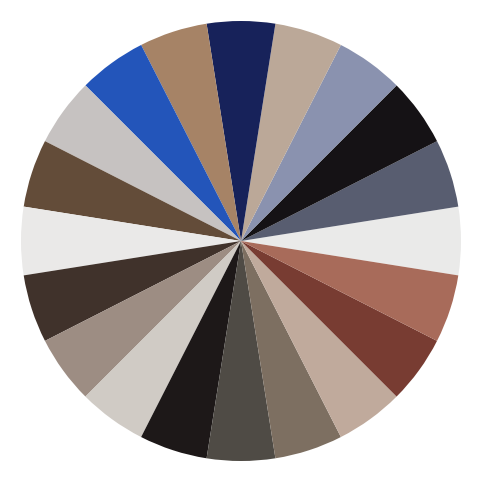

In [67]:
# Convert the final palette to a usable color format
final_colors = [tuple(color / 255) for palette in palettes for color in palette]  # Normalize to [0, 1] range

# Number of colors
num_colors = len(final_colors)

# Angles for the color wheel
angles = np.linspace(0, 2 * np.pi, num_colors, endpoint=False)

# Create a polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 6))
bars = ax.bar(angles, np.ones(num_colors), color=final_colors, width=2 * np.pi / num_colors)

# Remove radial and angular ticks
ax.set_yticks([])
ax.set_xticks([])
ax.spines['polar'].set_visible(False)

# Display the color wheel
plt.show()
